In [68]:
# References
# https://www.kaggle.com/code/vbmokin/nh4-tsaug-time-series-augmentation/notebook

In [69]:
from datetime import datetime, timedelta

import tsaug
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse
from tsaug.visualization import plot

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go

In [70]:
date_format = '%Y-%m-%d'
def date_parser(x):
	return datetime.strptime(x, date_format)

# map_date = np.vectorize(lambda x: datetime.fromtimestamp(x/1000.0))

In [71]:
file = './data/gcp_cost.csv'
# Date column index is 2
df = pd.read_csv(file, sep=',', header=0, parse_dates=[2],
                  date_parser=date_parser,  dtype={'gcpId': str})
df = df[['date', 'costInUsd', 'gcpId']].sort_values('date')
df = df.dropna()
instanceId = '2084983531904533635'
df_i = df[df['gcpId'] == instanceId]
df_i

,date,costInUsd,gcpId
2,2022-09-07,0.211182,2084983531904533635
4716,2022-09-08,0.702127,2084983531904533635
777,2022-09-09,0.951576,2084983531904533635
314,2022-09-10,0.601327,2084983531904533635
5535,2022-09-11,1.064413,2084983531904533635
3713,2022-09-12,0.871386,2084983531904533635
5186,2022-09-13,0.534156,2084983531904533635
2917,2022-09-14,0.953047,2084983531904533635
4695,2022-09-15,0.753425,2084983531904533635
2188,2022-09-16,1.002926,2084983531904533635


In [72]:
start_date = df_i.min(axis=0)['date']
end_date = df_i.max(axis=0)['date']
days_range = end_date - start_date + timedelta(days=1)
print(f"{start_date} -> {end_date}: {days_range} days", )

2022-09-07 00:00:00 -> 2022-10-03 00:00:00: 27 days 00:00:00 days


In [73]:
X = np.arange(len(df_i))
X_date = df_i['date'].map(lambda x: int(x.timestamp()*1000)).tolist()

In [74]:
Y = df_i['costInUsd'].tolist()
Y = np.array(Y)

In [75]:
### AUGMENTATION HERE
def add_noise(Y, X, scale=0.1):
    Y_aug_noise, X_aug_noise = tsaug.AddNoise(scale=scale).augment(Y, X)
    return Y_aug_noise, X_aug_noise

def add_drift(Y, X, max_drift=0.5, n_drift_points=5):
    Y_aug_drift, X_aug_drift = tsaug.Drift(max_drift=max_drift, n_drift_points=n_drift_points).augment(Y, X)
    return Y_aug_drift, X_aug_drift

In [76]:
len(Y)

27

In [77]:
Y_aug_noise, X_aug_noise = add_noise(Y, X)
Y_aug_drift, X_aug_drift = add_drift(Y, X)

In [78]:
def draw_plot_px2(title_plot, X_aug, Y_aug, label1, X_aug2, Y_aug2, label2):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=X_aug, y=Y_aug,
                        mode='lines',
                        name=label1))
    fig.add_trace(go.Scatter(x=X_aug2, y=Y_aug2,
                        mode='lines',
                        name=label2))
    fig.add_trace(go.Scatter(x=X, y=Y,
                        mode='lines',
                        name='Origin data'))
    fig.update_layout(title=title_plot)
    fig.show()

In [79]:
draw_plot_px2('GCP_cost_March-Sept',X_aug_noise, Y_aug_noise, 'after_add_noise', X_aug_drift, Y_aug_drift, 'after_add_drift')

In [80]:
NUM_OF_PERIODS = 10
X_date_extended1 = pd.date_range(start_date -(days_range) * NUM_OF_PERIODS,start_date,freq='d').map(lambda x: int(x.timestamp()*1000))
X_date_extended = np.hstack([X_date_extended1, X_date])[1:]

In [81]:
# Start executing add extended_Y, add noise to each result
extended_Y = []
cur_Y = Y
for i in range(0, NUM_OF_PERIODS):
    cur_Y, X = add_noise(cur_Y, X)
    extended_Y.append(cur_Y)

Y_extended = np.hstack([Y] + extended_Y)

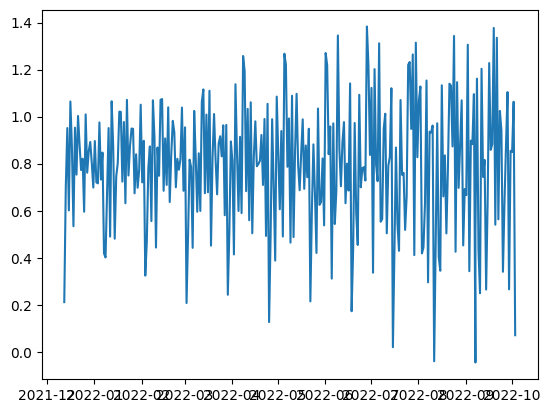

In [82]:
vfunc = np.vectorize(lambda x: datetime.fromtimestamp(x/1000.0))
plt.plot(vfunc(X_date_extended), Y_extended)

In [83]:
df_cost = pd.DataFrame({'datetime': list(map(lambda x: datetime.fromtimestamp(x/1000.0).strftime('%Y-%m-%d'),X_date_extended))})
df_cost['cost'] = pd.Series(Y_extended) 

In [84]:
df_cost.to_csv('./data/final_augemented_gcp_cost.csv')

In [85]:
metrics_file = './data/gcp_metrics_augmented.csv'
df_metrics = pd.read_csv(metrics_file, sep=',')[['datetime', 'cpuUtilization']]

In [86]:
merged_df = pd.merge(df_metrics, df_cost, on='datetime', how='outer')

In [87]:
display(merged_df)

,datetime,cpuUtilization,cost
0,2021-12-22,0.010492,0.882563
1,2021-12-23,0.009063,0.773161
2,2021-12-24,0.009381,0.821134
3,2021-12-25,0.009093,0.595643
4,2021-12-26,0.009061,1.009519
...,...,...,...
294,2021-12-18,NaN,0.534156
295,2021-12-19,NaN,0.953047
296,2021-12-20,NaN,0.753425
297,2021-12-21,NaN,1.002926


In [88]:
merged_df.to_csv('./data/augmented_gcp_cost_metrics.csv')